<a href="https://colab.research.google.com/github/dynamodenis/Google-Deep-Learning-LLM-Models/blob/main/NeuralNetwork/Mitigate_Overfitting_gdm_lab_3_6_mitigate_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> <p><small><small>This Notebook is made available subject to the licence and terms set out in the <a href = "http://www.github.com/google-deepmind/ai-foundations">AI Research Foundations Github README file</a>.

<img src="https://storage.googleapis.com/dm-educational/assets/ai_foundations/GDM-Labs-banner-image-C3-white-bg.png">

# Lab: Mitigate Overfitting

<a href='https://colab.research.google.com/github/google-deepmind/ai-foundations/blob/master/course_3/gdm_lab_3_6_mitigate_overfitting.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

Apply weight decay, dropout, and early stopping to prevent overfitting.

25 minutes

## Overview

In the previous activity, you explored how large models can easily overfit to small datasets. In this lab, you will continue your work tuning hyperparameters. You will take on the role of a researcher and experiment with three common tools to **control overfitting**:
- **Weight decay**: A method that penalizes large weights.
- **Dropout**: Randomly sets output of neurons to 0 during training.
- **Early stopping**: Stops training once the test loss starts getting worse.

As you perform each experiment you will keep a record of how well each method works.




### What you will learn:

By the end of this lab, you will:
* Understand how applying weight decay, dropout, and early stopping affects a model's ability to generalize.


### Tasks

In this lab, you will again use the dataset from the previous labs in which the classifier aims to predict the next token from the three words "mat", "apple", and "bank". You will again train models with different hyperparameters and investigate their learning behavior through inspecting the learning curves, their accuracy, and their decision boundaries.

**In this lab, you will**:
* Load the dataset of 2-dimensional embeddings.
* Set different hyperparameters.
* Train the models and plot the learning curve and decision boundary.

All of these steps are described in detail in the following sections.

## How to use Google Colaboratory (Colab)

Google Colaboratory (also known as Google Colab) is a platform that allows you to run Python code in your browser. The code is written in *cells* that are executed on a remote server.

To run a cell, hover over a cell and click on the `run` button to its left. The run button is the circle with the triangle (▶). Alternatively, you can also click on a cell and use the keyboard combination Ctrl+Return (or ⌘+Return if you are using a Mac).

To try this out, run the following cell. This should print today's day of the week below it.

In [ ]:
from datetime import datetime

print(f"Today is {datetime.today():%A}.")

Note that the order in which you run the cells matters. When you are working through a lab, make sure to always run all cells in order, otherwise the code might not work. If you take a break while working on a lab, Colab may disconnect you and in that case, you have to execute all cells again before  continuing your work. To make this easier, you can select the cell you are currently working on and then choose __Runtime → Run before__  from the menu above (or use the keyboard combination Ctrl/⌘ + F8). This will re-execute all cells before the current one.

## Imports

In this lab, you will primarily use functions from the custom `ai_foundations` package for training the model and for creating plots.

Run the following cell to import all required packages.

In [1]:
%%capture
# Install the custom package for this course.
!pip install "git+https://github.com/google-deepmind/ai-foundations.git@main"

import os # For adjusting Keras settings.
os.environ["KERAS_BACKEND"] = "jax" # Set a parameter for Keras.

# Packages used.
from collections import namedtuple # For storing hyperparameter configs.
import keras # For defining your MLP.
import jax.numpy as jnp # For defining matrices.
import pandas as pd # For loading the dataset.
# For splitting data into train and test splits.
from sklearn import model_selection

from ai_foundations import machine_learning # For training your MLP.
from ai_foundations import visualizations # For visualizing data and boundaries.
from ai_foundations import training # For logging the loss during training.

## Load the dataset

Run the following cell to load the dataset and prepare the `jax.Arrays` with the training and test data. As in the previous lab, the data here is split manually into a training set and a test set such that the most challenging examples (all outliers) appear in the test set.

In [2]:
# Load data using pandas.
df = pd.read_csv("https://storage.googleapis.com/dm-educational/assets/ai_foundations/mat-apple-bank-dataset.csv")

# Extract embeddings (Embedding_dim_1, Embedding_dim_2) and labels.
X = jnp.array(df[["Embedding_dim_1", "Embedding_dim_2"]].values)
# Labels: 0 ("mat"), 1 ("apple"), or 2 ("bank").
y = jnp.array(df["Label"].values)

# Human-readable labels.
labels = ["mat", "apple", "bank"]

# Manually split the data.
X_train, X_test, y_train, y_test = X[0:61, :], X[61:, :], y[0:61], y[61:]

## An MLP with dropout

The following cell implements an MLP that works with dropout. Crucially, dropout is applied *only during training*, and therefore when you generate predictions from the model, you have to specify whether this prediction happens during training or during testing.

As discussed in the previous article, dropout works by randomly setting neurons to 0, which makes the network more robust to differences in input. The model defined in the following cell, adds dropout to the output of each hidden layer. This can be done by adding a `keras.layers.Dropout` operation. The dropout rate (`dropout_rate`) defines the probability with which a neuron's value is set to 0.

In [3]:
def build_mlp(
    hidden_dims: list[int], n_classes: int, dropout_rate: float
) -> keras.Model:
    """
    A function that builds an MLP with a SoftMax layer as the output
    layer. After each hidden layer dropout is applied.

    Args:
      hidden_dims: A list of dimensions for all hidden layers.
      n_classses: Number of classes for the output layer.
      dropout_rate: Dropout rate, the probability with which a neuron's value is
        set to 0.

    Returns:
      A list of operations in the form of Keras Layer instances.
    """
    operations = []
    for dim in hidden_dims:
        operations.append(keras.layers.Dense(dim))
        operations.append(keras.layers.Activation("relu"))
        operations.append(keras.layers.Dropout(dropout_rate))

    operations.append(keras.layers.Dense(n_classes))  # Output layer: n_classes.
    operations.append(keras.layers.Softmax())

    return keras.Sequential(operations)

## Tune hyperparameters

In the following cells, you will change one hyperparameter at a time. For each set of hyperparameters, you will train and evaluate a model. You will also inspect the loss curves and accuracy curves for each training run.

Run the following cell to define a function that performs the training and visualizations for a given set of hyperparameters. In this function, you will see all components required for training a model, such as the loss function and the optimizer. For now, ignore these details. You will learn more about each of these components in later articles and labs.

In [4]:
# A named tuple for storing hyperparameter configurations.
HyperParameterConfig = namedtuple(
    "HyperParameterConfig",
    [
        "hidden_dims",
        "dropout_rate",
        "weight_decay_strength",
        "use_early_stopping",
    ],
)

# A dictionary to store the results of all your experiments.
experiment_log = {}


def train_and_visualize(
    hidden_dims: tuple[int, ...] | list[int],
    dropout_rate: float,
    weight_decay_strength: float,
    use_early_stopping: bool,
):
    keras.utils.set_random_seed(124)  # For reproducibility.
    model = build_mlp(list(hidden_dims), 3, dropout_rate)

    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    learning_rate = 0.01
    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate, weight_decay=weight_decay_strength
    )

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

    epochs = 400
    # Set the patience parameter for early stopping. After this many epochs of
    # the test loss going up, the model will stop training.
    patience = 20

    training_logger = training.CustomAccuracyPrinter(print_every=20)

    callbacks = [training_logger]
    if use_early_stopping:
        callbacks.append(
            keras.callbacks.EarlyStopping(
                monitor="val_loss", verbose=1, patience=patience
            )
        )

    # Train the model with early stopping.
    training_history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        verbose=0,
        callbacks=callbacks,
    )

    # Plot loss curves and accuracy curves.
    visualizations.plot_loss_curve(training_history.history)
    visualizations.plot_accuracy_curve(training_history.history)

    visualizations.plot_data_and_mlp(
        X_train,
        y_train,
        labels=labels,
        features_test=X_test,
        label_ids_test=y_test,
        mlp_model=model,
        title="Decision Boundaries",
    )

    print(f"Final test loss: {training_history.history['val_loss'][-1]}")
    print(
        f"Final test accuracy:"
        f" {training_history.history['val_accuracy'][-1]*100:.2f}%"
    )

### The baseline: A first set of hyperparameters

The following cell defines the first set of hyperparameters. This will serve as the baseline that you will compare every other run to. For the purpose of this activity, the hyperparameters in there have been chosen such that the model has too much capacity. This means it is very prone to overfitting. Instead of fixing the model capacity, you will explore other strategies for mitigating overfitting.

In this baseline configuration, all other strategies have been disabled.

Run the following cell to define this set of parameters, train the model, and generate the visualizations.

Epoch 19: Training loss: 0.00706, training accuracy: 100.00%, test loss: 0.08087, test accuracy: 100.00%
Epoch 39: Training loss: 0.00060, training accuracy: 100.00%, test loss: 0.08428, test accuracy: 100.00%
Epoch 59: Training loss: 0.00021, training accuracy: 100.00%, test loss: 0.10904, test accuracy: 91.67%
Epoch 79: Training loss: 0.00006, training accuracy: 100.00%, test loss: 0.15405, test accuracy: 91.67%
Epoch 99: Training loss: 0.00002, training accuracy: 100.00%, test loss: 0.22358, test accuracy: 91.67%
Epoch 119: Training loss: 0.00001, training accuracy: 100.00%, test loss: 0.28595, test accuracy: 91.67%
Epoch 139: Training loss: 0.00001, training accuracy: 100.00%, test loss: 0.32969, test accuracy: 91.67%
Epoch 159: Training loss: 0.00001, training accuracy: 100.00%, test loss: 0.37819, test accuracy: 91.67%
Epoch 179: Training loss: 0.00000, training accuracy: 100.00%, test loss: 0.42128, test accuracy: 91.67%
Epoch 199: Training loss: 0.00000, training accuracy: 100.

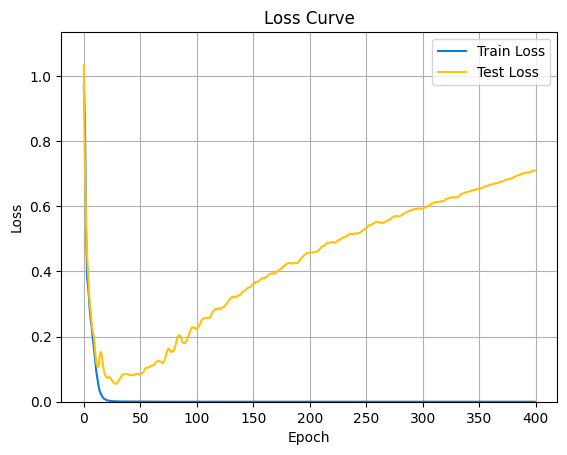

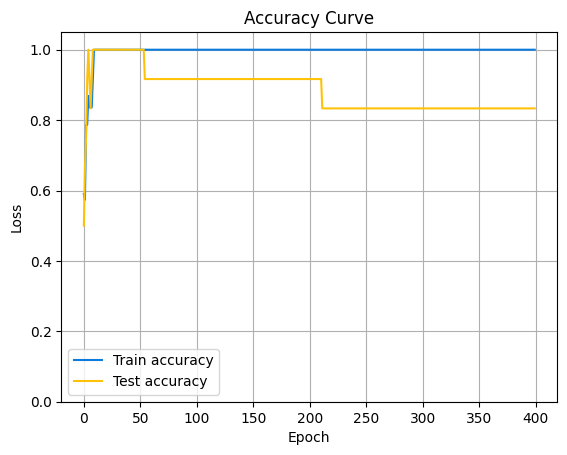

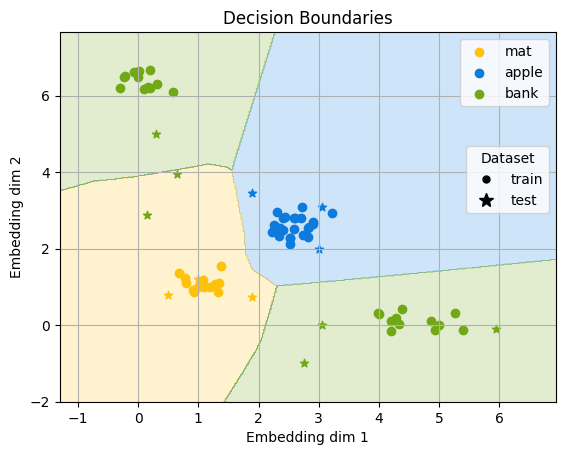

Final test loss: 0.7095727920532227
Final test accuracy: 83.33%


In [5]:
hyperparameters_baseline = HyperParameterConfig(
    hidden_dims=(10, 1000), # Define MLP with many parameters.
    dropout_rate=0.0, # Dropout rate of 0.0 means no dropout is applied.
    weight_decay_strength=0.00, # Value of 0.0 means no weight decay.
    use_early_stopping=False # Early stopping is not enabled.
)

train_and_visualize(*hyperparameters_baseline)

#### What did you observe?

In the training run above, you likely observed that the test loss curve steadily increases after a small number of epochs and continues to increase. Furthermore, the accuracy continues to decrease as you continue training the model. Both of these trends are classic signs of an **overfitting model**.

<br />

------
> **ℹ️ Research skills focus: Experiment log**
>
> When experimenting with different methods for mitigating overfitting, you should keep a record of how well each of the methods works. In practice, researchers often perform many dozens or even hundreds of model training runs with different hyperparameters to determine which hyperparameters work best for a given dataset and task. As you take on the role of a researcher and perform these experiments, it is important that you keep a record of all results. This will enable you to effectively analyze and compare them.
>
> To do this, this lab defines a dictionary `experiment_log` which you can fill with the final test loss of every run. At the end of this lab, you will be able to visualize how each of the hyperparameters affected the test loss, which provides an indication of which models generalize well.
>
> The following cell already contains the loss from the baseline experiment. Run the next cell to save the result.
------

In [6]:
# Save the final test loss from the baseline experiment.
experiment_log[hyperparameters_baseline] = 0.7096465229988098

### Coding activity 1: Early stopping

------
> **💻 Your task:**
>
>The first overfitting mitigation strategy that you will explore is early stopping. Enter the hyperparameters below. Use the exact settings from the baseline experiment, making only one change: **activate early stopping**. This will allow you to see the direct effect of using early stopping. Every other aspect about the training process is the same between the baseline experiment and the experiment below, so any change in the test loss can be attributed to activating early stopping.
>
------

Epoch 19: Training loss: 0.00706, training accuracy: 100.00%, test loss: 0.08087, test accuracy: 100.00%
Epoch 39: Training loss: 0.00060, training accuracy: 100.00%, test loss: 0.08428, test accuracy: 100.00%
Epoch 49: early stopping


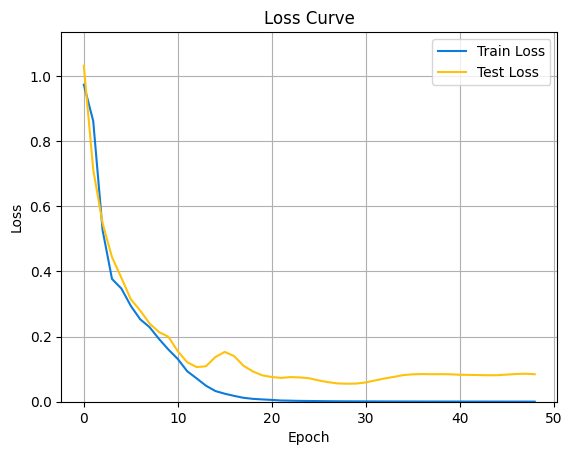

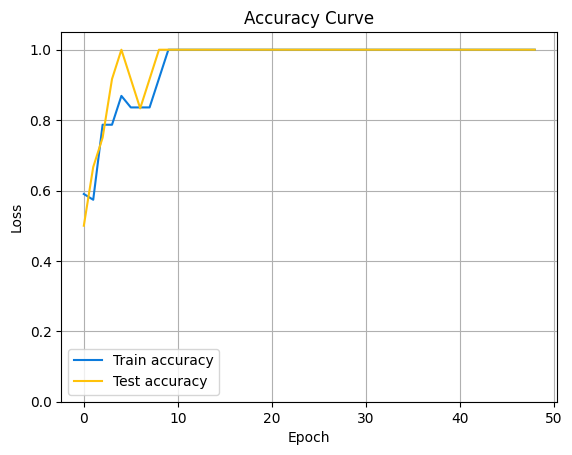

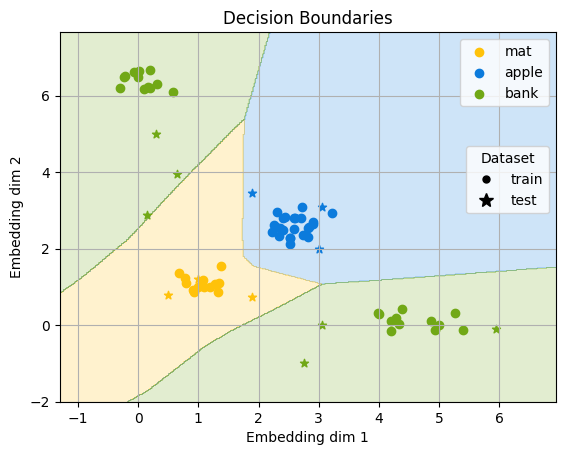

Final test loss: 0.08434680849313736
Final test accuracy: 100.00%


In [7]:
# Set the hyperparameters here.
hyperparameters_early_stopping = HyperParameterConfig(
    hidden_dims=(10, 1000),
    dropout_rate=0.0,
    weight_decay_strength=0.00,
    use_early_stopping=True
)

train_and_visualize(*hyperparameters_early_stopping)

#### What did you observe?

In the training run with early stopping, you likely observed that the test loss didn't increase much. This is because the early stopping mechanism terminated the process as soon as the loss started rising (in this case, after 49 epochs). This also resulted in higher accuracy for this run. The model successfully classified all test data points correctly, avoiding overfitting to the training data patterns.

Add the final test loss in the cell below and run it to store this experimental result.


In [8]:
# Add the final test loss from the early stopping experiment here.
experiment_log[hyperparameters_early_stopping] =0.08434680849313736

### Coding activity 2: Medium dropout

------
> **💻 Your task:**
>
> In this activity, you will experiment with dropout. Fill in the hyperparameters below. Keep all settings the same as the baseline experiment, but set the dropout rate to 0.3. This will instruct the model to set the ouput of each neuron in the hidden layers to 0 with a probability of 0.3 during training.
>
------


Epoch 19: Training loss: 0.15023, training accuracy: 98.36%, test loss: 0.09691, test accuracy: 100.00%
Epoch 39: Training loss: 0.07251, training accuracy: 100.00%, test loss: 0.07647, test accuracy: 100.00%
Epoch 59: Training loss: 0.07893, training accuracy: 98.36%, test loss: 0.05485, test accuracy: 100.00%
Epoch 79: Training loss: 0.07802, training accuracy: 98.36%, test loss: 0.02948, test accuracy: 100.00%
Epoch 99: Training loss: 0.08985, training accuracy: 96.72%, test loss: 0.06640, test accuracy: 100.00%
Epoch 119: Training loss: 0.09659, training accuracy: 98.36%, test loss: 0.02991, test accuracy: 100.00%
Epoch 139: Training loss: 0.10817, training accuracy: 96.72%, test loss: 0.01928, test accuracy: 100.00%
Epoch 159: Training loss: 0.09669, training accuracy: 96.72%, test loss: 0.11401, test accuracy: 91.67%
Epoch 179: Training loss: 0.04832, training accuracy: 96.72%, test loss: 0.31388, test accuracy: 83.33%
Epoch 199: Training loss: 0.05764, training accuracy: 98.36%,

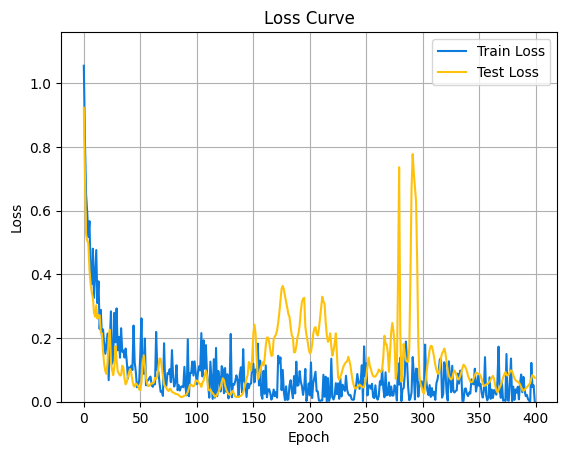

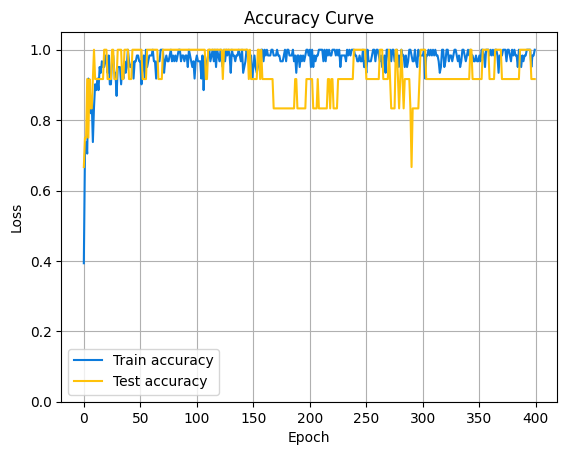

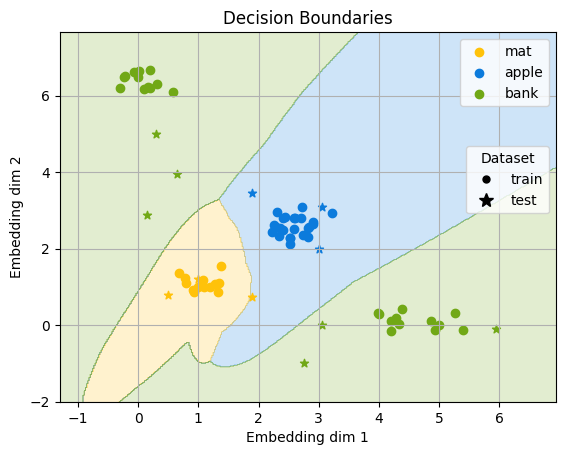

Final test loss: 0.07518089562654495
Final test accuracy: 91.67%


In [9]:
# Set the hyperparameters here.
hyperparameters_dropout_medium = HyperParameterConfig(
    hidden_dims=(10, 1000),
    dropout_rate=0.3,
    weight_decay_strength=0.00,
    use_early_stopping=False
)

train_and_visualize(*hyperparameters_dropout_medium)

#### What did you observe?

In the training run with a dropout rate of 0.3, you likely observed that both the training and the test loss fluctuated considerably from epoch to epoch. This is due to the random nature of dropout. However, this strategy worked. While for some epochs the test loss increased, it generally remained low even as you trained the model for many epochs. This is because dropout prevents the model from latching onto noise. This occurs because the random nature of dropout means the outputs of the neurons change on every epoch, as it is randomly decided which outputs are set to 0.

Add the final test loss in the cell below and run it to store this experimental result.


In [10]:
experiment_log[hyperparameters_dropout_medium] =0.07518089562654495

### Coding activity 3: High dropout

------
> **💻 Your task:**
>
> In this activity, you will experiment with more dropout. Fill in the hyperparameters below. Ensure that all settings remain the same as in the baseline experiment, but set the dropout rate to 0.7. This will instruct the model to set the ouput of each neuron in the hidden layers to 0 with a probability of 0.7 during training. This means that, on average, more than half of the neurons in each layer is randomly deactivated (i.e., their output set to 0), introducing considerable noise into the training process.
>
------


Epoch 19: Training loss: 0.76612, training accuracy: 57.38%, test loss: 0.57178, test accuracy: 75.00%
Epoch 39: Training loss: 0.56298, training accuracy: 77.05%, test loss: 0.46839, test accuracy: 91.67%
Epoch 59: Training loss: 0.68779, training accuracy: 67.21%, test loss: 0.71485, test accuracy: 66.67%
Epoch 79: Training loss: 0.33823, training accuracy: 85.25%, test loss: 0.50693, test accuracy: 66.67%
Epoch 99: Training loss: 0.54265, training accuracy: 72.13%, test loss: 0.71069, test accuracy: 66.67%
Epoch 119: Training loss: 0.47352, training accuracy: 81.97%, test loss: 1.87399, test accuracy: 50.00%
Epoch 139: Training loss: 0.46623, training accuracy: 75.41%, test loss: 1.78675, test accuracy: 50.00%
Epoch 159: Training loss: 0.45414, training accuracy: 73.77%, test loss: 2.03063, test accuracy: 50.00%
Epoch 179: Training loss: 0.57868, training accuracy: 77.05%, test loss: 2.38131, test accuracy: 50.00%
Epoch 199: Training loss: 0.41565, training accuracy: 83.61%, test lo

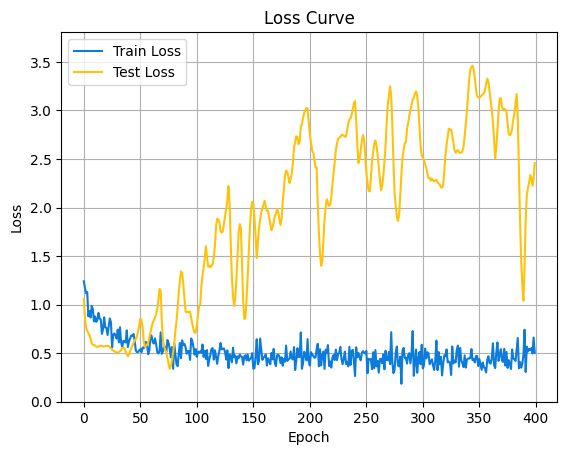

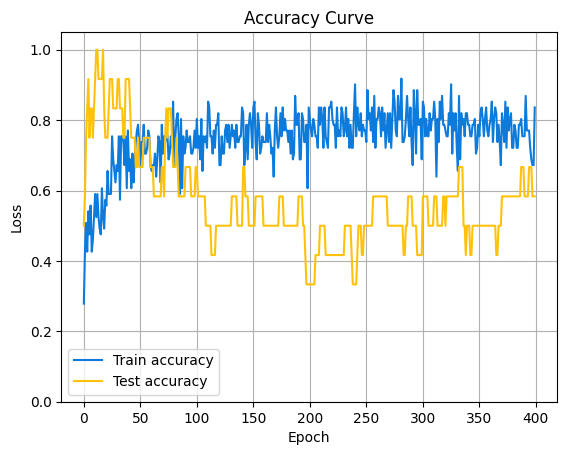

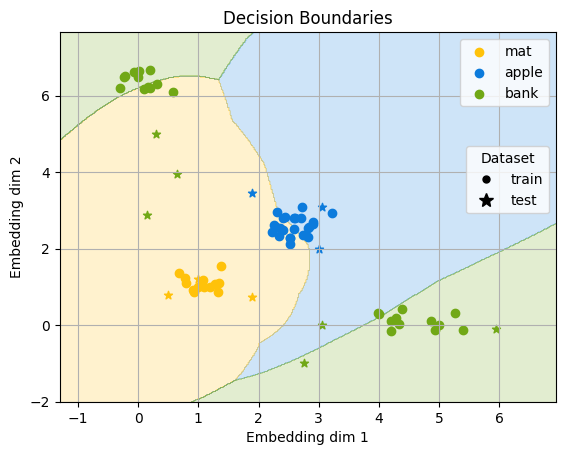

Final test loss: 2.4573543071746826
Final test accuracy: 58.33%


In [11]:
# Set the hyperparameters here.
hyperparameters_dropout_high = HyperParameterConfig(
    hidden_dims=(10, 1000),
    dropout_rate= 0.7,
    weight_decay_strength= 0.00,
    use_early_stopping= False
)

train_and_visualize(*hyperparameters_dropout_high)

#### What did you observe?

In the training run with a dropout rate of 0.7, you likely observed that the training loss and test loss fluctuated even more between epochs. This is again because of the random nature of dropout.
With such a high value of dropout, the strategy no longer works properly. When the dropout probability is so high, it introduces so much noise that the model is no longer able to learn the signal. This leads to it misclassifying both examples in the training data and the test data. Consequently it **underfits**.

This highlights that methods like dropout must be used in moderation. If you add too much randomness, then the model will also fail to learn useful patterns and will not be able to generalize well.

Add the final test loss in the cell below and run it to store this experimental result.


In [12]:
experiment_log[hyperparameters_dropout_high] = 2.4573543071746826

### Coding activity 4: Medium weight decay strength

------
> **💻 Your task:**
>
> In this activity, you will experiment with the weight decay strength. Fill in the hyperparameters below. Ensure that all settings remain the same as in the baseline experiment, but set the weight decay strength to 0.5. This will instruct the training procedure to penalize weights that are very big in magnitude and assign a lower loss to simpler models.
>
------


Epoch 19: Training loss: 0.01152, training accuracy: 100.00%, test loss: 0.07851, test accuracy: 100.00%
Epoch 39: Training loss: 0.00294, training accuracy: 100.00%, test loss: 0.12851, test accuracy: 91.67%
Epoch 59: Training loss: 0.00149, training accuracy: 100.00%, test loss: 0.20404, test accuracy: 91.67%
Epoch 79: Training loss: 0.00073, training accuracy: 100.00%, test loss: 0.27801, test accuracy: 91.67%
Epoch 99: Training loss: 0.00062, training accuracy: 100.00%, test loss: 0.32879, test accuracy: 91.67%
Epoch 119: Training loss: 0.00059, training accuracy: 100.00%, test loss: 0.35342, test accuracy: 91.67%
Epoch 139: Training loss: 0.00043, training accuracy: 100.00%, test loss: 0.35448, test accuracy: 91.67%
Epoch 159: Training loss: 0.00035, training accuracy: 100.00%, test loss: 0.36739, test accuracy: 91.67%
Epoch 179: Training loss: 0.00020, training accuracy: 100.00%, test loss: 0.41945, test accuracy: 91.67%
Epoch 199: Training loss: 0.00016, training accuracy: 100.0

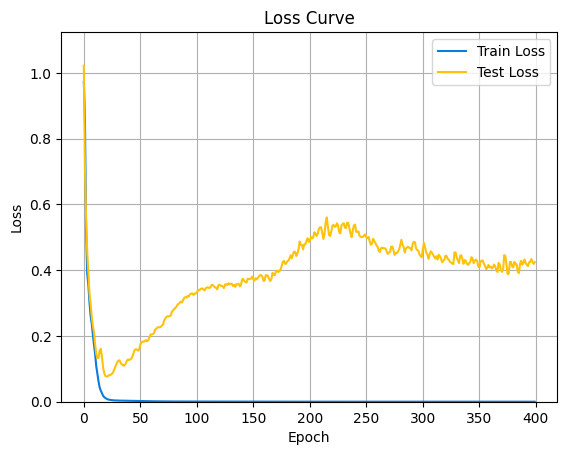

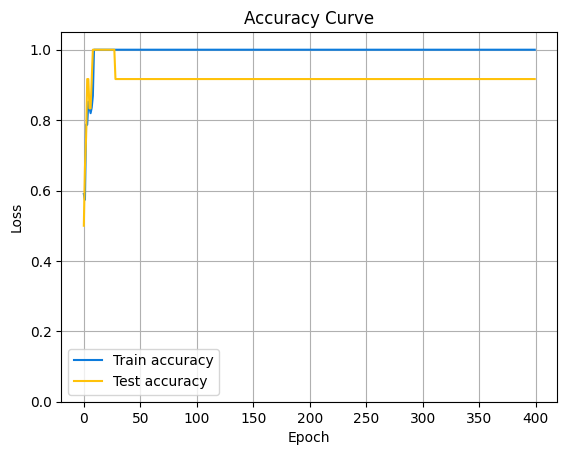

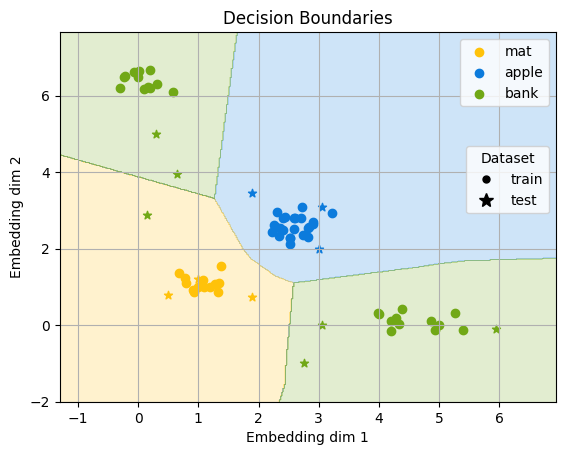

Final test loss: 0.42485305666923523
Final test accuracy: 91.67%


In [13]:
# Set the hyperparameters here.
hyperparameters_weight_decay_medium = HyperParameterConfig(
    hidden_dims=(10, 1000),
    dropout_rate=0.0,
    weight_decay_strength=0.5,
    use_early_stopping=False
)

train_and_visualize(*hyperparameters_weight_decay_medium)

#### What did you observe?

In the training run with weight decay strength of 0.5, you likely observed that the test loss increased much more slowly than in the baseline model. This is because the model is penalized for learning very strong associations with patterns in the training data and is therefore less prone to overfitting.

Add the final test loss in the cell below and run it to store this experimental result.


In [14]:
experiment_log[hyperparameters_weight_decay_medium] =0.42485305666923523

### Coding activity 5: High weight decay strength

------
> **💻 Your task:**
>
> In this activity, you will experiment with the weight decay strength. Fill in the hyperparameters below. Ensure that all settings remain the same as in the baseline experiment, but set the weight decay strength to 50 i.e., 100 times higher than in the previous experiment. This will instruct the training procedure to put an even stronger penalty on weights that are very big in magnitude and assign a lower loss to simpler models.
>
------


Epoch 19: Training loss: 1.07355, training accuracy: 39.34%, test loss: 1.08261, test accuracy: 25.00%
Epoch 39: Training loss: 1.05614, training accuracy: 29.51%, test loss: 1.06800, test accuracy: 50.00%
Epoch 59: Training loss: 1.05861, training accuracy: 39.34%, test loss: 1.07227, test accuracy: 25.00%
Epoch 79: Training loss: 1.06072, training accuracy: 36.07%, test loss: 1.07334, test accuracy: 50.00%
Epoch 99: Training loss: 1.06193, training accuracy: 39.34%, test loss: 1.07412, test accuracy: 50.00%
Epoch 119: Training loss: 1.06444, training accuracy: 39.34%, test loss: 1.07538, test accuracy: 25.00%
Epoch 139: Training loss: 1.06094, training accuracy: 39.34%, test loss: 1.07373, test accuracy: 50.00%
Epoch 159: Training loss: 1.05312, training accuracy: 39.34%, test loss: 1.06935, test accuracy: 25.00%
Epoch 179: Training loss: 1.04116, training accuracy: 39.34%, test loss: 1.05882, test accuracy: 50.00%
Epoch 199: Training loss: 1.03371, training accuracy: 39.34%, test lo

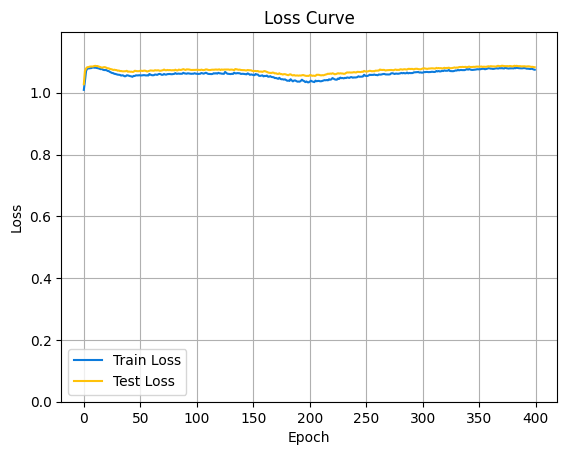

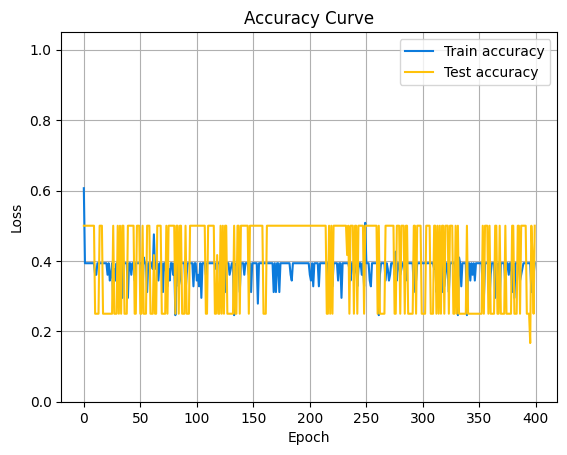

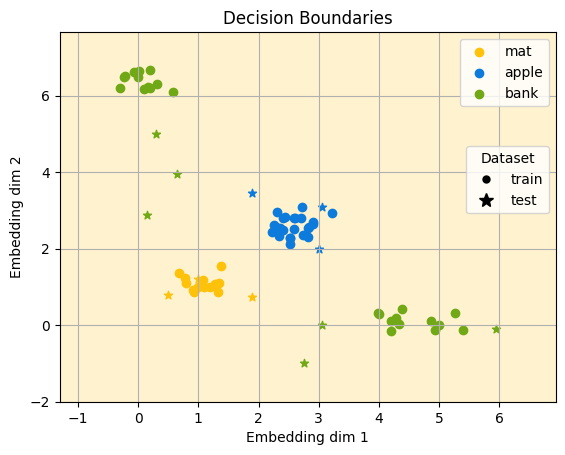

Final test loss: 1.0826328992843628
Final test accuracy: 50.00%


In [15]:
# Set the hyperparameters here.
hyperparameters_weight_decay_high = HyperParameterConfig(
    hidden_dims=(10, 1000),
    dropout_rate=0.0,
    weight_decay_strength=50,
    use_early_stopping=False
)

train_and_visualize(*hyperparameters_weight_decay_high)

#### What did you observe?

In the training run with a weight decay strength of 50.0, you likely observed that the model failed to learn anything. Similar to when you set the dropout rate to too high a value, using too much weight decay also leads to underfitting and the model neither does well on examples in its training data nor on examples in its test data.

Add the final test loss in the cell below and run it to store this experimental result.

In [16]:
experiment_log[hyperparameters_weight_decay_high] =1.0826328992843628

## Analyze the results

Throughout this lab, you have experimented with different combinations of hyperparameters, and you have kept track of how well the model generalized to the test dataset on each run.

You can now use this log to get a sense of how well the different settings work.

Run the following cell to visualize the relationship between the hyperparameter setting and the loss for each of the three hyperparameters. Before you run this cell, make sure that you have added the loss values to `experiment_log` for each of the experiments.






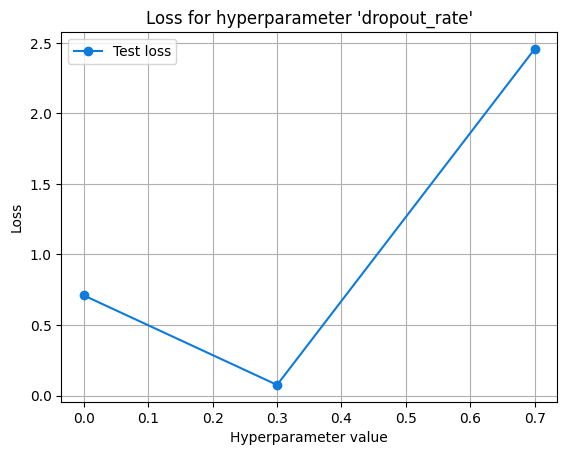

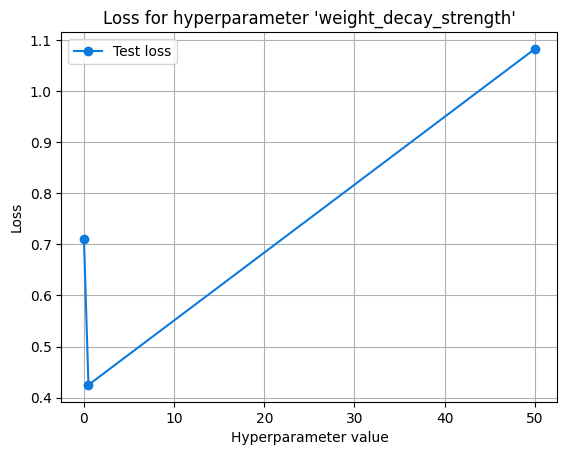

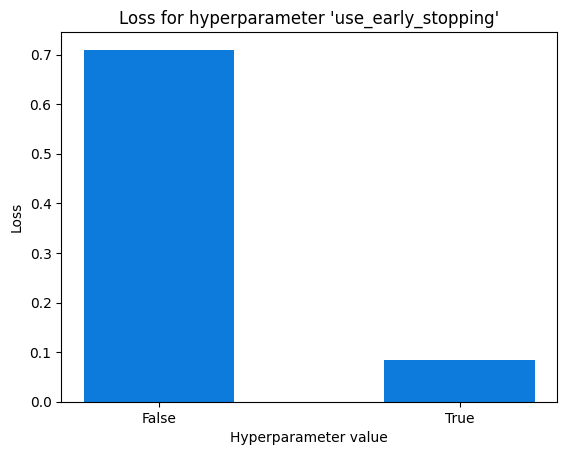

In [17]:
visualizations.visualize_hyperparameter_loss(experiment_log)

Inspect the plots above. Which of the overfitting methods worked well in terms of reducing the test loss? Which ones less so?

You probably noticed that for both the dropout rate and weight decay strength, the model's performance initially improved compared to the baseline when you set them to a smaller value. However, performance worsened significantly when you set either of these values too high. This is a very common pattern and usually you have to try several values until you find the one that works best for your model and dataset.

In this lab, you also modified one hyperparameter at a time. In practice, you often want to combine overfitting methods, for example dropout and early stopping. If you want to experiment further, add more cells to this lab and try out additional combinations of hyperparameters.

## Summary

In this activity, you took on the role of researcher who aims to find the best hyperparameters for their model to prevent overfitting. You experimented with the following three overfitting mitigation methods:
* Early stopping
* Dropout
* Weight decay

You also saw how keeping an **experiment log** can be used to visualize the relationship between hyperparameters and the loss on the test dataset. This will be a useful process when you are training your own models.

In the next activity, you will learn a bit more about hyperparameter tuning and learn why you want to have a separate dataset for tuning hyperparameters.

